<a href="https://colab.research.google.com/github/custom-hyper/Research/blob/main/Research_%E2%80%93_Event_Driven_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Setup

In [75]:
#@title Connect to FNS { display-mode: "code" }
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
#@title Install Libraries { display-mode: "code" }
!pip install plotly
!pip install pytrends
!pip install pycoingecko
!pip install pandas
!pip install tweepy
!pip install requests
!pip install pipreqs
!pip install configparser
!pip install psycopg2-binary==2.8.6


In [95]:
#@title Import Project  Dependencies { display-mode: "code" }
import requests
import datetime
import time
import json
from google.colab import data_table
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import logging
import sys
from tqdm.notebook import tqdm
import os
import sqlite3 as sq
import psycopg2 as pg
import configparser
from sqlalchemy import create_engine
from pycoingecko import CoinGeckoAPI
import numpy as np
from __future__ import division

## Setup SQLite


In [78]:
#@title  Connect { display-mode: "code" }
path = '/content/drive/MyDrive/workspace/pipelines/db/' #@param {type: 'string'
database = "db.sqlite" #@param {type: 'string'
conn_SQLite = sq.connect(path+database)

In [79]:
#@title   Show Available Tables { display-mode: "code" }
cursor = conn_SQLite.cursor()

%time
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
cursor.fetchall()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


[('deFi_lama_total_TVL',),
 ('deFi_lama_tvl',),
 ('deFi_lama_general',),
 ('deFi_lama_id',),
 ('proprietary_airtable_watch_all',),
 ('proprietary_Twitter_id',),
 ('proprietary_tweets_extract',),
 ('proprietary_Twitter_partnerships_announcements',),
 ('proprietary_master_id',),
 ('proprietary_Twitter_Partnership_ohlc',)]

 # Load Partnership Dataset

In [80]:
#@title Load Token ID to SQLite { display-mode: "code" }
token_ID  = "proprietary_Twitter_id"


df_token_ID = pd.read_sql('select * from {}'.format(token_ID), conn_SQLite)

df_token_ID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   twitter_screen_name  837 non-null    object
 1   CoinGecko_id         837 non-null    object
 2   prop_id              837 non-null    object
 3   name                 837 non-null    object
 4   symbol               837 non-null    object
dtypes: object(5)
memory usage: 32.8+ KB


In [ ]:
#@title Create Partnership Dataset { display-mode: "code" }
table_ID = "proprietary_Twitter_id a"
table_Extract = "proprietary_Twitter_partnerships_announcements b"

#twitter_screen_name, CoinGecko_id, prop_id, created_at, text
%time
df_proprietary_Twitter_partnerships_announcements = pd.read_sql(
    """
    SELECT a.name, a.twitter_screen_name, a.CoinGecko_id, a.prop_id, b.created_at, b.text
    FROM {} 
    LEFT JOIN {}
    ON 
    b.twitter_screen_name = a.twitter_screen_name
    WHERE b.text IS NOT NULL
    ;
    """.format(table_Extract, table_ID), conn_SQLite)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [ ]:
df_proprietary_Twitter_partnerships_announcements

,name,twitter_screen_name,CoinGecko_id,prop_id,created_at,text
0,01coin,01CoinTeam,01coin,ZOC.01coin,2022-02-15 19:38:08,The 01coin community is proud to announce a ne...
1,0xcert,0xcert,0xcert,ZXC.0xcert,2020-03-25 15:11:19,"🗣️As of today, we are also live with the ZXC/B..."
2,0xDAO,0xDAO_fi,0xdao,OXD.0xDAO,2022-03-17 17:50:47,0xDAO welcomes @Screamdotsh as an official veN...
3,0xDAO V2,0xDAO_fi,0xdao-v2,OXD V2.0xDAOV2,2022-03-17 17:50:47,0xDAO welcomes @Screamdotsh as an official veN...
4,0xDAO,0xDAO_fi,0xdao,OXD.0xDAO,2022-03-17 17:50:47,0xDAO welcomes @Screamdotsh as an official veN...
...,...,...,...,...,...,...
1413,Astar,AstarNetwork,astar,ASTR.Astar,2022-04-13 23:24:12,🌟🌟🌟New Partnership Announcement🌟🌟🌟\n\nAstar is...
1414,AST.finance,AST_Finance,ast-finance,AST.AST.finance,2021-09-01 19:28:52,"#AST continues to grow, scale up, and seek new..."
1415,Aston Martin Cognizant Fan Token,Chiliz,aston-martin-cognizant-fan-token,AM.AstonMartinCognizantFanToken,2022-04-14 09:58:54,RT @socios: A breakdown of our partners by spo...
1416,Aston Martin Cognizant Fan Token,Chiliz,aston-martin-cognizant-fan-token,AM.AstonMartinCognizantFanToken,2022-04-14 08:42:33,RT @alex_dreyfus: 127. That's the number of an...


Candle's body:

1 - 2 days: 30 minutes
3 - 30 days: 4 hours
31 and before: 4 days

# Load Prices

In [90]:
#@title Load Prices { display-mode: "code" }
cg = CoinGeckoAPI()
CoinGecko_id = df_proprietary_Twitter_partnerships_announcements['CoinGecko_id']
frames = []
days = [1,30,"max"]

try:

  for i in tqdm(CoinGecko_id):

    a = cg.get_coin_ohlc_by_id(id=i, vs_currency='usd', days = "max")

    df = pd.DataFrame(data=a, columns = ['Date','Open','High', 'Low', 'Close',])
    df['CoinGecko_id'] = str(i)

    print(df.tail())
    frames.append(df)
    time.sleep(60/50)
except ConnectionError:
    time.sleep(60)
single = pd.concat(frames) #Careful, this line must be outside of the for loop

single.head()

  0%|          | 0/1418 [00:00<?, ?it/s]

ValueError: ignored

In [173]:
#@title Load Token ID to SQLite { display-mode: "code" }

proprietary_Twitter_Partnership_ohlc = "proprietary_Twitter_Partnership_ohlc"

single.to_sql(proprietary_Twitter_Partnership_ohlc, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

proprietary_Twitter_Partnership_ohlc = pd.read_sql('select * from {}'.format(proprietary_Twitter_Partnership_ohlc), conn_SQLite)

In [174]:
proprietary_Twitter_Partnership_ohlc.head()

,Date,Open,High,Low,Close,CoinGecko_id
0,1536969600000,0.009788,0.009788,0.009788,0.009788,01coin
1,1537315200000,0.009883,0.012145,0.007965,0.011866,01coin
2,1537660800000,0.011457,0.012510,0.009856,0.012510,01coin
3,1538006400000,0.008730,0.010058,0.008105,0.008105,01coin
4,1538265600000,0.009297,0.009297,0.007109,0.007109,01coin


In [82]:
proprietary_Twitter_Partnership_ohlc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42387 entries, 0 to 42386
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          42387 non-null  int64  
 1   Open          42387 non-null  float64
 2   High          42387 non-null  float64
 3   Low           42387 non-null  float64
 4   Close         42387 non-null  float64
 5   CoinGecko_id  42387 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.9+ MB


In [ ]:
proprietary_Twitter_Partnership_ohlc.keys()


Index(['Date', 'Open', 'High', 'Low', 'Close', 'CoinGecko_id'], dtype='object')

# Create Features

In [180]:

data = proprietary_Twitter_Partnership_ohlc

,Date,Open,High,Low,Close,CoinGecko_id
0,1536969600000,0.009788,0.009788,0.009788,0.009788,01coin
1,1537315200000,0.009883,0.012145,0.007965,0.011866,01coin
2,1537660800000,0.011457,0.012510,0.009856,0.012510,01coin
3,1538006400000,0.008730,0.010058,0.008105,0.008105,01coin
4,1538265600000,0.009297,0.009297,0.007109,0.007109,01coin
...,...,...,...,...,...,...
42382,1648944000000,1.240000,1.270000,1.240000,1.250000,aston-martin-cognizant-fan-token
42383,1649289600000,1.300000,1.300000,1.050000,1.050000,aston-martin-cognizant-fan-token
42384,1649635200000,1.050000,1.050000,1.010000,1.020000,aston-martin-cognizant-fan-token
42385,1649980800000,0.973581,1.090000,0.973581,1.020000,aston-martin-cognizant-fan-token


In [185]:
data = proprietary_Twitter_Partnership_ohlc
token_list = data['CoinGecko_id'].unique()
frames = []

#@title Simple Moving Averages { display-mode: "code" }
for  i in token_list:
  data_token = data[data['CoinGecko_id'] == i]
  data_token['SMA10'] = data_token['Close'].rolling(10).mean()
  data_token['SMA20'] = data_token['Close'].rolling(20).mean()
  data_token['SMA50'] = data_token['Close'].rolling(50).mean()
  data_token['SMA100'] = data_token['Close'].rolling(100).mean()
  data_token['SMA200'] = data_token['Close'].rolling(200).mean()
  data_token['returns_1d'] = np.log(data_token['Close'] / data_token['Close'].shift(1))
  data_token['returns_7d'] = np.log(data_token['Close'] / data_token['Close'].shift(7))
  frames.append(data_token)

single = pd.concat(frames) #Careful, this line must be outside of the for loop
single.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

,Date,Open,High,Low,Close,CoinGecko_id,SMA10,SMA20,SMA50,SMA100,SMA200
0,1536969600000,0.009788,0.009788,0.009788,0.009788,01coin,NaN,NaN,NaN,NaN,NaN
1,1537315200000,0.009883,0.012145,0.007965,0.011866,01coin,NaN,NaN,NaN,NaN,NaN
2,1537660800000,0.011457,0.012510,0.009856,0.012510,01coin,NaN,NaN,NaN,NaN,NaN
3,1538006400000,0.008730,0.010058,0.008105,0.008105,01coin,NaN,NaN,NaN,NaN,NaN
4,1538265600000,0.009297,0.009297,0.007109,0.007109,01coin,NaN,NaN,NaN,NaN,NaN


In [186]:
single.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42387 entries, 0 to 42386
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          42387 non-null  int64  
 1   Open          42387 non-null  float64
 2   High          42387 non-null  float64
 3   Low           42387 non-null  float64
 4   Close         42387 non-null  float64
 5   CoinGecko_id  42387 non-null  object 
 6   SMA10         40952 non-null  float64
 7   SMA20         39417 non-null  float64
 8   SMA50         35393 non-null  float64
 9   SMA100        30536 non-null  float64
 10  SMA200        24297 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 3.9+ MB


In [184]:
Past = '/content/event.csv'
single.to_csv(Past)

In [119]:
1. #@title Returns { display-mode: "code" }
for  i in data['CoinGecko_id']:
  data['returns_1d'] = np.log(data['Close'] / data['Close'].shift(1))
  data['returns_7d'] = np.log(data['Close'] / data['Close'].shift(7))


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyboardInterrupt: ignored

In [ ]:
#@title Average True Range { display-mode: "code" }

In [92]:

data[data['CoinGecko_id'] == "01coin"]

,Date,Open,High,Low,Close,CoinGecko_id
0,1536969600000,0.009788,0.009788,0.009788,0.009788,01coin
1,1537315200000,0.009883,0.012145,0.007965,0.011866,01coin
2,1537660800000,0.011457,0.012510,0.009856,0.012510,01coin
3,1538006400000,0.008730,0.010058,0.008105,0.008105,01coin
4,1538265600000,0.009297,0.009297,0.007109,0.007109,01coin
...,...,...,...,...,...,...
338,1648944000000,0.000706,0.000706,0.000463,0.000466,01coin
339,1649289600000,0.000467,0.000467,0.000436,0.000436,01coin
340,1649635200000,0.000611,0.000611,0.000424,0.000424,01coin
341,1649980800000,0.000420,0.000435,0.000359,0.000359,01coin


In [ ]:
data.tail()

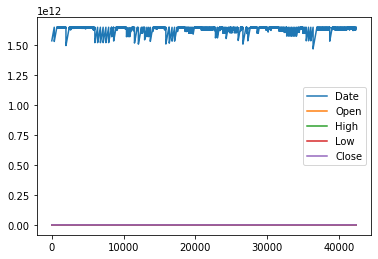

In [86]:
data.plot()